# Load libs

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import glob

In [3]:
from keras.layers import Conv2DTranspose, Conv2D, Input, MaxPooling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.models import Model

# Setup global params

In [4]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 50

# Load labels

In [4]:
def load_labels(polygon_folder, bbox_folder, output_folder):
    """
    Load polygon and bbox labels for images with the same prefix and combine them.

    Parameters:
    - polygon_folder: Path to the folder containing polygon label files.
    - bbox_folder: Path to the folder containing bbox label files.
    - output_folder: Path to save the merged label files.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Get list of polygon and bbox label files
    polygon_files = sorted(os.listdir(polygon_folder))
    bbox_files = sorted(os.listdir(bbox_folder))

    # Combine labels for files with the same prefix
    for polygon_file in polygon_files:
        prefix = os.path.splitext(polygon_file)[0]  # Extract file prefix (e.g., "image1")

        # Check if a corresponding bbox file exists
        bbox_file = f"{prefix}.txt"
        if bbox_file in bbox_files:
            polygon_path = os.path.join(polygon_folder, polygon_file)
            bbox_path = os.path.join(bbox_folder, bbox_file)
            output_path = os.path.join(output_folder, f"{prefix}.txt")

            # Load and merge labels
            with open(polygon_path, 'r') as poly_file, open(bbox_path, 'r') as bbox_file:
                poly_data = poly_file.readlines()
                bbox_data = bbox_file.readlines()

            # Write combined labels to the output file
            with open(output_path, 'w') as output_file:
                output_file.writelines(poly_data)  # Write polygon labels
                output_file.writelines(bbox_data)  # Write bbox labels

            print(f"Merged labels for {prefix} saved to {output_path}")
        else:
            print(f"No corresponding bbox file found for {prefix}. Skipping...")

In [10]:
label_folder = "/Users/thanhhuongtran/Documents/him/seed-size/newdata/merged_labels/"      
image_folder = "/Users/thanhhuongtran/Documents/him/seed-size/data_train/images/"                    
image_size = (256, 256)   

# Load data

In [5]:
def load_mask(image_shape, label_file, visualize=False):
    """
    Load label file and convert it to a mask, with optional visualization.
    Label format: <label_id> x1 y1 x2 y2 x3 y3 x4 y4 ...
    Both polygon and bbox will be marked as 1 in binary mask
    
    Args:
    - image_shape: Tuple (height, width) of the image
    - label_file: Path to the label file
    - visualize: Boolean to control whether to show the visualization
    
    Returns:
    - mask: NumPy array with labels (1 for both polygon and bbox)
    """
    # Binary mask - using 1 for both polygon and bbox
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Colored mask for visualization
    vis_mask = np.zeros((*image_shape[:2], 3), dtype=np.uint8)
    colors = {
        0: (0, 255, 0),    # Green for oriented bbox
        1: (255, 0, 0)     # Red for polygon
    }
    
    try:
        with open(label_file, 'r') as file:
            for line in file:
                line = line.strip()
                if not line:
                    continue
                
                values = list(map(float, line.split()))
                if len(values) < 9:
                    continue
                    
                label_id = int(values[0])
                coords = values[1:]
                
                points = []
                for i in range(0, len(coords), 2):
                    x = int(coords[i] * image_shape[1])
                    y = int(coords[i + 1] * image_shape[0])
                    points.append([x, y])
                points = np.array(points, dtype=np.int32)
                
                # Fill binary mask with 1 for both polygon and bbox
                cv2.fillPoly(mask, [points], color=1)
                # Fill colored mask with respective colors
                cv2.fillPoly(vis_mask, [points], color=colors[label_id])
                
        if visualize:
            plt.figure(figsize=(15, 5))
            
            # Plot binary mask
            plt.subplot(131)
            plt.imshow(mask, cmap='gray')
            plt.title('Binary Mask\n(1 for both polygon and bbox)')
            plt.axis('off')
            
            # Plot colored mask
            plt.subplot(132)
            plt.imshow(vis_mask)
            plt.title('Colored Mask\nRed: Polygon, Green: Bbox')
            plt.axis('off')
            
            # Plot overlay
            plt.subplot(133)
            plt.imshow(mask, cmap='gray')
            plt.imshow(vis_mask, alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
                
    except Exception as e:
        print(f"Error processing file {label_file}: {str(e)}")
        return mask
        
    return mask

In [6]:
image_dir = "/Users/thanhhuongtran/Documents/him/seed-size/dataset_close_full/images/train"
label_dir = "/Users/thanhhuongtran/Documents/him/seed-size/dataset_close_full/merged_labels/train"

In [7]:
# Đọc danh sách file
images = sorted(glob.glob(f"{image_dir}/*.JPG") + glob.glob(f"{image_dir}/*.jpg"))
labels = sorted(glob.glob(f"{label_dir}/*.txt"))

In [8]:
print(len(images))

500


In [9]:
image_size = (256, 256)
X = []  # Ảnh gốc
y = []  # Mask

# Lặp qua từng cặp ảnh và nhãn
for img_path, lbl_path in zip(images, labels):
    # Đọc ảnh
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, image_size)
    X.append(img_resized)

    # Tạo mask
    mask = load_mask(img.shape, lbl_path)  # Mask theo kích thước gốc
    mask_resized = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    y.append(mask_resized)

# Chuyển sang dạng NumPy array
X = np.array(X, dtype=np.float32) / 255.0  # Normalize ảnh
y = np.expand_dims(np.array(y, dtype=np.float32), axis=-1)

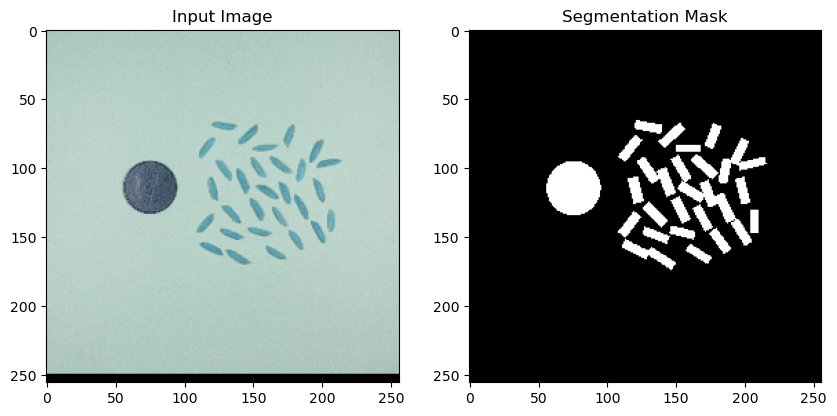

In [14]:
import matplotlib.pyplot as plt

# Hiển thị ảnh và mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0])  # Hiển thị ảnh
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(y[0].squeeze(), cmap="gray")  # Hiển thị mask
plt.title("Segmentation Mask")
plt.show()

Total number of seeds across all images: 16489
Average seeds per image: 32.98
Max seeds in an image: 200
Min seeds in an image: 6


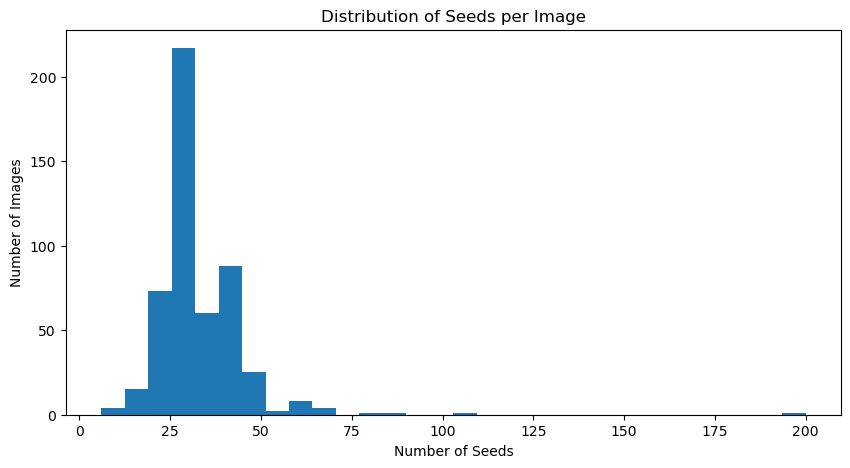

In [15]:
def count_labels(label_file):
    """
    Count number of labels in a file
    
    Args:
    - label_file: Path to the label file
    
    Returns:
    - count: Number of labels (seeds) in the file
    """
    count = 0
    try:
        with open(label_file, 'r') as file:
            for line in file:
                line = line.strip()
                if line:  # Skip empty lines
                    count += 1
    except Exception as e:
        print(f"Error processing file {label_file}: {str(e)}")
    return count

# Count total seeds across all label files
total_seeds = 0
seeds_per_image = []

for label_path in labels:
    num_seeds = count_labels(label_path)
    total_seeds += num_seeds
    seeds_per_image.append(num_seeds)

# Print statistics
print(f"Total number of seeds across all images: {total_seeds}")
print(f"Average seeds per image: {total_seeds/len(labels):.2f}")
print(f"Max seeds in an image: {max(seeds_per_image)}")
print(f"Min seeds in an image: {min(seeds_per_image)}")

# Optional: Plot distribution of seeds per image
plt.figure(figsize=(10, 5))
plt.hist(seeds_per_image, bins=30)
plt.title('Distribution of Seeds per Image')
plt.xlabel('Number of Seeds')
plt.ylabel('Number of Images')
plt.show()

# Build model

In [10]:
def conv_block(x, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def up_concat_block(x, skip, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, skip])
    x = conv_block(x, filters)
    return x

def unet_plus_plus_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # --------------------- ENCODER ---------------------
    # block 1
    c1_0 = conv_block(inputs, 64)         # X_1,0
    p1_0 = MaxPooling2D((2, 2))(c1_0)

    # block 2
    c2_0 = conv_block(p1_0, 128)         # X_2,0
    p2_0 = MaxPooling2D((2, 2))(c2_0)

    # block 3
    c3_0 = conv_block(p2_0, 256)         # X_3,0
    p3_0 = MaxPooling2D((2, 2))(c3_0)

    # block 4
    c4_0 = conv_block(p3_0, 512)         # X_4,0
    p4_0 = MaxPooling2D((2, 2))(c4_0)

    # bottleneck
    c5_0 = conv_block(p4_0, 1024)        # X_5,0 (bottleneck)

    # --------------------- DECODER: STAGE 1 ---------------------
    # Mỗi tầng up từ bottleneck/đầu ra trước và concat với encoder
    c4_1 = up_concat_block(c5_0, c4_0, 512)   # X_4,1
    c3_1 = up_concat_block(c4_0, c3_0, 256)   # X_3,1
    c2_1 = up_concat_block(c3_0, c2_0, 128)   # X_2,1
    c1_1 = up_concat_block(c2_0, c1_0, 64)    # X_1,1

    # --------------------- DECODER: STAGE 2 (++ connections) ---------------------
    # Kết hợp thêm skip của stage 1 + skip gốc encoder
    x4_2_input = concatenate([c4_1, c4_0])
    c4_2 = up_concat_block(c5_0, x4_2_input, 512)

    x3_2_input = concatenate([c3_1, c3_0])
    c3_2 = up_concat_block(c4_1, x3_2_input, 256)

    x2_2_input = concatenate([c2_1, c2_0])
    c2_2 = up_concat_block(c3_1, x2_2_input, 128)

    x1_2_input = concatenate([c1_1, c1_0])
    c1_2 = up_concat_block(c2_1, x1_2_input, 64)

    # Output cuối (chọn c1_2)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c1_2)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.176)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (350, 256, 256, 3)
y_train shape: (350, 256, 256, 1)
X_test shape : (75, 256, 256, 3)
y_test shape : (75, 256, 256, 1)
X_valid shape: (75, 256, 256, 3)
y_valid shape: (75, 256, 256, 1)


In [16]:
model = unet_plus_plus_model(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30)

Epoch 1/30


/Users/thanhhuongtran/miniconda3/envs/seed/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 301s 26s/step - accuracy: 0.9357 - loss: 0.4245 - val_accuracy: 0.9317 - val_loss: 0.2105
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 277s 25s/step - accuracy: 0.9365 - loss: 0.1931 - val_accuracy: 0.9317 - val_loss: 0.1687
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 312s 29s/step - accuracy: 0.9377 - loss: 0.1533 - val_accuracy: 0.9317 - val_loss: 0.1309
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 294s 27s/step - accuracy: 0.9380 - loss: 0.1331 - val_accuracy: 0.9507 - val_loss: 0.1084
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 275s 25s/step - accuracy: 0.9630 - loss: 0.0921 - val_accuracy: 0.9396 - val_loss: 0.4137
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 280s 26s/step - accuracy: 0.9540 - loss: 0.2534 - val_accuracy: 0.9413 - val_loss: 0.1535
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 274s 25s/step - accuracy: 0.9601 - loss: 0.1070 - val_accuracy: 0.9817 - val_loss: 0.0697
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 270s 25s/step - accuracy: 0.9850 - loss: 0.0502 - val_accuracy: 0.9830 - val_

In [18]:
model.save("unetpp_model.h5")

In [22]:
pip install scikit-image scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 35.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, auc

In [20]:
def compute_iou(pred_mask, gt_mask):
    """Compute IoU between predicted mask and ground truth mask"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

In [21]:
def compute_ap(precisions, recalls):
    """Compute Average Precision (AP) using Area Under Curve (AUC)"""
    return auc(recalls, precisions) if len(precisions) > 1 else 0

In [22]:
def evaluate_map(model, x_test, y_test, thresholds=[0.5]):
    """Compute mAP for given IoU thresholds"""
    
    # Get model predictions
    y_pred = model.predict(x_test)
    
    # Convert predictions and ground truth to binary (0 or 1)
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Threshold predictions
    y_test_bin = (y_test > 0.5).astype(np.uint8)  # Ensure ground truth is binary
    
    all_aps = []

    for iou_thresh in thresholds:
        ious = np.array([compute_iou(pred, gt) for pred, gt in zip(y_pred_bin, y_test_bin)])
        
        # Compute precision-recall curve
        precisions, recalls, _ = precision_recall_curve(ious >= iou_thresh, ious)
        
        # Compute AP using AUC
        ap = compute_ap(precisions, recalls)
        all_aps.append(ap)
    
    return np.mean(all_aps)  # Return mean AP (mAP)

In [23]:
# Compute mAP@0.5
mAP_50 = evaluate_map(model, X_test, y_test, thresholds=[0.5])
print(f"mAP@0.5: {mAP_50:.4f}")

# Compute mAP@50-95 (COCO-style evaluation)
mAP_50_95 = evaluate_map(model, X_test, y_test, thresholds=np.arange(0.5, 1.0, 0.05))
print(f"mAP@50-95: {mAP_50_95:.4f}")

/Users/thanhhuongtran/miniconda3/envs/seed/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step
mAP@0.5: 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step
mAP@50-95: 0.9500


/Users/thanhhuongtran/miniconda3/envs/seed/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [24]:
def compute_dice(pred_mask, gt_mask):
    """
    Compute the Dice Coefficient between two binary masks.
    Dice = 2 * (Intersection) / (Total number of pixels in both masks)
    """
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    dice = (2 * intersection) / (pred_mask.sum() + gt_mask.sum() + 1e-7)  # avoid division by zero
    return dice

In [25]:
def pixel_accuracy(pred_mask, gt_mask):
    """
    Compute pixel-wise accuracy between the predicted and ground truth masks.
    """
    return (pred_mask == gt_mask).sum() / gt_mask.size

In [26]:

def evaluate_instance_metrics(pred_masks, gt_masks):
    """
    Given lists of predicted and ground truth instance masks,
    compute mean IoU, mean Dice coefficient, and mean Pixel Accuracy.
    
    Parameters:
      - pred_masks: list or array of predicted masks (binary or thresholded)
      - gt_masks: list or array of ground truth masks (binary)
      
    Returns:
      - Dictionary containing the computed metrics.
    """
    
    iou_scores = []
    dice_scores = []
    pixel_accs = []
    
    # Iterate over each instance (assuming one predicted mask corresponds to one ground truth mask)
    for pred, gt in zip(pred_masks, gt_masks):
        # Optionally, ensure binary masks (for instance, using thresholding if your masks are probabilities)
        if pred.dtype != np.bool_:
            pred = (pred > 0.5).astype(np.uint8)
        if gt.dtype != np.bool_:
            gt = (gt > 0.5).astype(np.uint8)
        
        iou = compute_iou(pred, gt)
        dice = compute_dice(pred, gt)
        acc = pixel_accuracy(pred, gt)
        
        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accs.append(acc)
    
    metrics = {
        'Mean IoU': np.mean(iou_scores),
        'Mean Dice': np.mean(dice_scores),
        'Mean Pixel Accuracy': np.mean(pixel_accs)
    }
    
    return metrics

In [27]:
y_pred = model.predict(X_test)

# In many cases, your predictions might be probabilities or logits. 
# You can convert them to binary masks using thresholding.
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_test_bin = (y_test > 0.5).astype(np.uint8)

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step


In [28]:
# Compute the metrics:
metrics = evaluate_instance_metrics(y_pred_bin, y_test_bin)
print("Evaluation Metrics for Instance Segmentation:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

Evaluation Metrics for Instance Segmentation:
Mean IoU: 0.8767
Mean Dice: 0.9341
Mean Pixel Accuracy: 0.9912


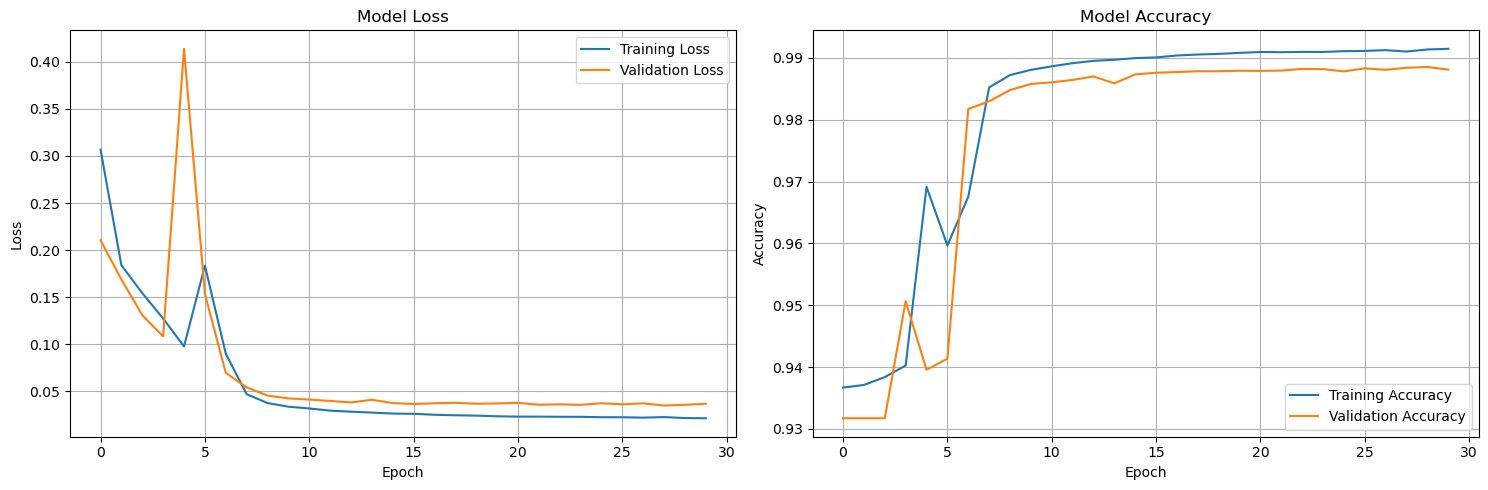


Final Training Metrics:
Training Loss: 0.0215
Validation Loss: 0.0369
Training Accuracy: 0.9915
Validation Accuracy: 0.9881


In [30]:
# Plot training history
def plot_training_history(history):
    """
    Plot training history showing loss and accuracy curves
    
    Args:
    - history: History object returned by model.fit()
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final values
    print("\nFinal Training Metrics:")
    print(f"Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot the training history
plot_training_history(hist)  # Assuming 'history' is the output from model.fit()